This code imports the gravity wave signals, conditions them, turns them into spectrograms and then runs a CNN.
Reused a lot of Anthony Fishers code here for the CNN.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython.display import display
from sklearn import model_selection, preprocessing
from scipy import signal
from scipy.fft import fftshift

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Data

In [3]:
# Following load code adapted from:
#  https://www.kaggle.com/xuzongniubi/g2net-efficientnet-b7-baseline-training

train_meta = pd.read_csv('data/training_labels.csv')
test_meta = pd.read_csv('data/sample_submission.csv')

def get_train_file_path(image_id):
    return "data/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "data/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train_meta['file_path'] = train_meta['id'].apply(get_train_file_path)
test_meta['file_path'] = test_meta['id'].apply(get_test_file_path)

label_dict = pd.Series(train_meta.target.values,index=train_meta.id).to_dict()


## Some Constants

In [4]:
#sampling frequency
fs = 2048


tmax = 232
tmin = 11
fmax = 143
fmin = 15

## Signal Conditioning

In [5]:
#Bandpass filter constants
fo = 20 #filter order
flo = 20 #filter lower freq
fhi = 500 #filter upper freq

#define filter
#sos = signal.butter(fo, [flo, fhi], 'bandpass', fs=fs, output='sos')


## Make Spectrograms

In [10]:
def rawSpect(tser):
    fsp, tsp, Sxx = signal.spectrogram(tser, fs=2048, window=('tukey', 0.5), nperseg=768, noverlap=744)
    return fsp, tsp, Sxx


def MakeSpectrograms(data, normalize=True, size=None, filt=True):
    tmax = 232
    tmin = 11
    fmax = 143
    fmin = 15
    #Bandpass filter constants
    fo = 20 #filter order
    flo = 20 #filter lower freq
    fhi = 500 #filter upper freq
    #define filter
    sos = signal.butter(fo, [flo, fhi], 'bandpass', fs=fs, output='sos')
    for i in range(len(data)):
        #Filter
        if filt == True:
            tseries0 = signal.sosfilt(sos, (data[i, :, 0]*10**20).astype('float32'))
            tseries1 = signal.sosfilt(sos, (data[i, :, 1]*10**20).astype('float32'))
            tseries2 = signal.sosfilt(sos, (data[i, :, 2]*10**20).astype('float32'))
        else:
            tseries0 = data[i, :, 0]*10**20
            tseries1 = data[i, :, 1]*10**20
            tseries2 = data[i, :, 2]*10**20
        #Generate spectrogram
        fsp0, tsp0, Sxx0 = rawSpect(tseries0)
        fsp1, tsp1, Sxx1 = rawSpect(tseries1)
        fsp2, tsp2, Sxx2 = rawSpect(tseries2)
        #Resize - note for now this was manually figured out to generate 128x128
        lSxx0 = Sxx0[fmin:fmax, tmin:]
        lSxx1 = Sxx1[fmin:fmax, tmin:]
        lSxx2 = Sxx2[fmin:fmax, tmin:]
        if normalize == True:
            #Convert values dB
            lSxx0 = np.log10(lSxx0)
            lSxx1 = np.log10(lSxx1)
            lSxx2 = np.log10(lSxx2)
            #Apply scaler
            scaler = preprocessing.MinMaxScaler()
            lSxx0 = scaler.fit_transform(lSxx0)
            lSxx1 = scaler.fit_transform(lSxx1)
            lSxx2 = scaler.fit_transform(lSxx2)
        #temp = np.stack((lSxx0.tolist(), lSxx0.tolist(), lSxx0.tolist()), axis=-1)
        temp = np.stack((lSxx0, lSxx1, lSxx2), axis=-1)
        if i == 0:
            print(temp.shape)
        
        #if (size is not None and len(size) == 2):
        #    temp2 = tf.image.resize(temp, size, preserve_aspect_ratio=True)
        
        # If on the first iteration, create an array to hold the data, now that we know the size.
        #    if (i == 0):
        #        spect = np.zeros((data.shape[0], temp2.shape[0], temp2.shape[1], 3))
        #        
        #
        #        spect[i] = temp2
        #else:
        if (i == 0):
            spect = np.zeros((data.shape[0], temp.shape[0], temp.shape[1], 3))
            
        
        spect[i] = temp

    return spect
        
        

In [7]:
def SaveSpectrograms(ids, size):
#     if (data.shape[0] != len(ids)):
#         print('Data and id arrays must be the same length')
#         return 1
    
#     print(f'ids shape = {ids.shape}')
    
    for i in ids:
#         print(f'i = {i}')
        raw = np.load("data/train/{}/{}/{}/{}.npy".format(i[0], i[1], i[2], i)).T
        raw = raw[np.newaxis, :, :]
#         print("raw shape = {}".format(raw.shape))
        d = MakeSpectrograms(raw, size=size, normalize=True)
#         print('d shape = {}'.format(d.shape))
        path = "data_{}x{}/train/{}/{}/{}/".format(d.shape[1],
                d.shape[2], i[0], i[1], i[2])
        Path(path).mkdir(parents=True, exist_ok=True)
        np.save(path + "{}.npy".format(i), d[0])

### Custom Keras Generator

From tutorial at: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
             n_classes=10, shuffle=True, resize_shape=None, apply_norm=True,
             apply_transforms=True):
        
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resize_shape = resize_shape
        self.apply_norm = apply_norm
        self.apply_transforms = apply_transforms
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if (self.apply_transforms):
                X[i,] = np.load("data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T
            else:
                X[i,] = np.load("data_{}x{}/train/{}/{}/{}/{}.npy".format(self.dim[0],
                                self.dim[1], ID[0], ID[1], ID[2], ID))

            # Store class
            y[i] = self.labels[ID]

        # Not sure if I want this categorical transformation since I'm only doing
        # a binary classification, but I'll leave it for now.
        return X, y#tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X_raw, y = self.__data_generation(list_IDs_temp)
        
        if (self.apply_transforms):
            X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        else:
            X = X_raw
        
#         self.out_shape = X[0].shape

        return X, y
    
    def GetOutputShape(self):
        if (self.apply_transforms):
            ID = self.list_IDs[0]

            # Initialization
            X_raw = np.empty((1, *self.dim, self.n_channels))
            y = np.empty((1), dtype=int)

            # Generate data
            # Store sample
            X_raw[0,] = np.load("data/train/{}/{}/{}/{}.npy".format(ID[0], ID[1], ID[2], ID)).T

            if (self.apply_transforms):
                X = MakeSpectrograms(X_raw, size=self.resize_shape, normalize=self.apply_norm)
        
            return X[0].shape
        else:
            return (*self.dim, self.n_channels)

## Data Selection

In [63]:
starting_sample = 0
num_samples = 100000
end_idx = starting_sample + num_samples
id_list = train_meta['id'][starting_sample : end_idx].to_numpy()
label_list = [label_dict[k] for k in id_list]

X_train, X_val = model_selection.train_test_split(id_list, test_size=0.2, 
                                                    shuffle=True, random_state=42,
                                                    stratify=label_list)

print(X_train)
print(X_val)

# Params for raw data
params_raw = {'dim': np.array([4096]),
          'batch_size': 250,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'resize_shape': (128, 128),
          'apply_norm': True,
          'apply_transforms': True}

# Params for transformed data
params_trans = {'dim': np.array([128, 128]),
          'batch_size': 250,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'resize_shape': (128, 128),
          'apply_norm': True,
          'apply_transforms': False}

train_gen = DataGenerator(X_train, label_dict, **params_raw)
val_gen = DataGenerator(X_val, label_dict, **params_raw)

data_shape = train_gen.GetOutputShape()



['02131797a3' '02916569fb' '0bd4c827b0' ... '02e929c746' '0f9a62216a'
 '1ac588175b']
['0a92aaa7b2' '129331fa9e' '2d82d91dd1' ... '1b56f16225' '120a985d67'
 '16c84d307d']
(128, 128, 3)


(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(250, 128, 128, 3) (250,)


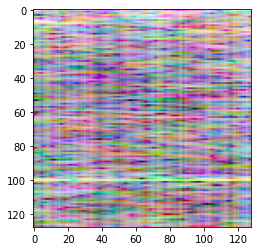

(128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3) ()


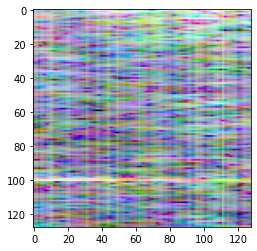

In [64]:
foo, bar = train_gen[0]
print(foo.shape, bar.shape)
plt.imshow(foo[0])
plt.show()

foo2, bar2 = val_gen[0]
print(foo2[0].shape, bar2[1].shape)
plt.imshow(foo2[0])

In [65]:
foo[0, :, :, 2]

array([[1.        , 1.        , 1.        , ..., 0.93484071, 0.85544654,
        0.8014256 ],
       [0.7152956 , 0.75388383, 0.75052847, ..., 0.90561838, 0.85768458,
        0.78881165],
       [0.38591206, 0.50663413, 0.55113852, ..., 0.92820141, 0.87472979,
        0.86527527],
       ...,
       [0.35203237, 0.31067559, 0.17810906, ..., 0.74336115, 0.5187552 ,
        0.34213371],
       [0.54316961, 0.63241765, 0.66766297, ..., 0.74793118, 0.59273462,
        0.49553039],
       [0.27094078, 0.29118735, 0.2854232 , ..., 0.830314  , 0.75258398,
        0.71557527]])

## Build CNN

In [66]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(data_shape[0], data_shape[1], data_shape[2])))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.Dense(2, activation='softmax'))
# model.add(layers.SoftMax())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

Compile & Train

In [67]:
model.compile(optimizer='sgd',#'adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               loss='binary_crossentropy',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

history = model.fit(train_gen, validation_data=val_gen,
                     epochs=5)#, callbacks=[model_checkpoint_callback])

(128, 128, 3)
Epoch 1/5
(128, 128, 3)
320/320 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5129(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128,

(128, 128, 3)
(128, 128, 3)
80/80 [==============================] - 126s 2s/step - loss: 0.6811 - accuracy: 0.5928
0.5928000211715698


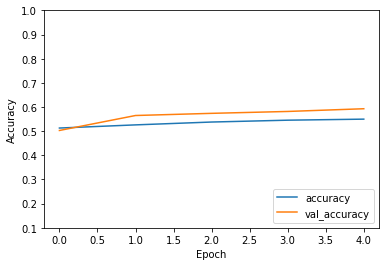

In [69]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_gen, verbose=1)

print(test_acc)



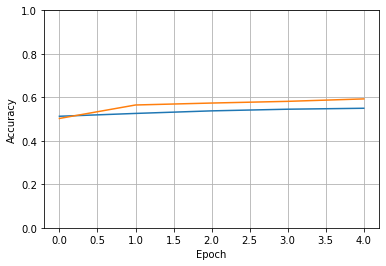

In [74]:
#pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
lt.legend(loc='lower right')
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()

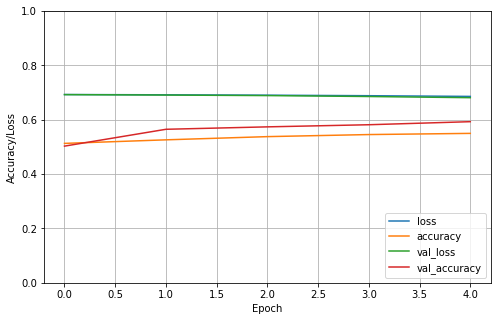

In [78]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()

In [73]:
history.history

{'loss': [0.6926798820495605,
  0.6916530728340149,
  0.6902902126312256,
  0.6883432269096375,
  0.6857615113258362],
 'accuracy': [0.5129125118255615,
  0.5259875059127808,
  0.5377874970436096,
  0.5454124808311462,
  0.5497375130653381],
 'val_loss': [0.6923356652259827,
  0.6907468438148499,
  0.6888179183006287,
  0.6854077577590942,
  0.6810763478279114],
 'val_accuracy': [0.5028499960899353,
  0.5648000240325928,
  0.5737500190734863,
  0.5815500020980835,
  0.5928000211715698]}

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig(\"keras_learning_curves_plot\")
plt.show()